##**Finding quality of beverage**

#### **Problem statement**
The dataset contained in Beverage.csv refers to different physiochemical properties of a beverage 
produced by a company. This dataset has 4898 observations, with 11 input variables (physiochemical 
properties) and 1 target variable (quality). 
Each row corresponds to a batch of produced beverage. Quality of each batch can be Poor, Normal or 
Excellent, and one of these labels is assigned by a beverage expert after tasting a sample from a given
batch.
The beverage manufacturing company does not want to rely on the beverage expert to label the quality 
of each batch and wants to build a classification (prediction) model that can predict batch quality on the 
basis of physiochemical properties.

#### *Random Forest*

We are going to build a random forest classification model to predict the quality of the product. We will perform all the data cleaning steps and split the data into train and test data. We will convert three-dimensional data into 2 dimensions by combining neutral and excellent quality samples. 

A random forest builds multiple decision trees by first creating multiple training sets using 
bootstrap sampling. 
In bootstrap sampling, we sample each observation with replacement from the training data set. 
Sampling with replacement means that we could sample the same observation more than once.
N decision trees are then constructed using N bootstrapped training sets. These trees are grown deep and are not pruned.
To make sure that these trees are different from one another, only a small random sample of predictors is considered at each split. This random sample size is typically the square root of 
the total number of predictors. 
For a given test observation, random forest records class prediction.

In [ ]:
#importing librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from imblearn.over_sampling import SMOTE  # imblearn library can be installed in Visual Studio by going into Python Environment -> Install new package -> imblearn package
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objs as go
import plotly .offline as offline
import plotly.figure_factory as ff

In [2]:
# Importing dataset and examining it
dataset = pd.read_csv("Beverage.csv")
print(dataset.head())
print(dataset.shape)
print(dataset.info())
print(dataset.describe())

   fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
0            7.0              0.27         0.36  ...       0.45      8.8   Normal
1            6.3              0.30         0.34  ...       0.49      9.5   Normal
2            8.1              0.28         0.40  ...       0.44     10.1   Normal
3            7.2              0.23         0.32  ...       0.40      9.9   Normal
4            7.2              0.23         0.32  ...       0.40      9.9   Normal

[5 rows x 12 columns]
(4898, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free 

In [ ]:
# Converting Categorical features into Numerical features
dataset['quality'] = dataset['quality'].map({'Poor':0, 'Normal':1, 'Excellent': 1})

# Plotting Correlation Heatmap
corrs = dataset.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
figure

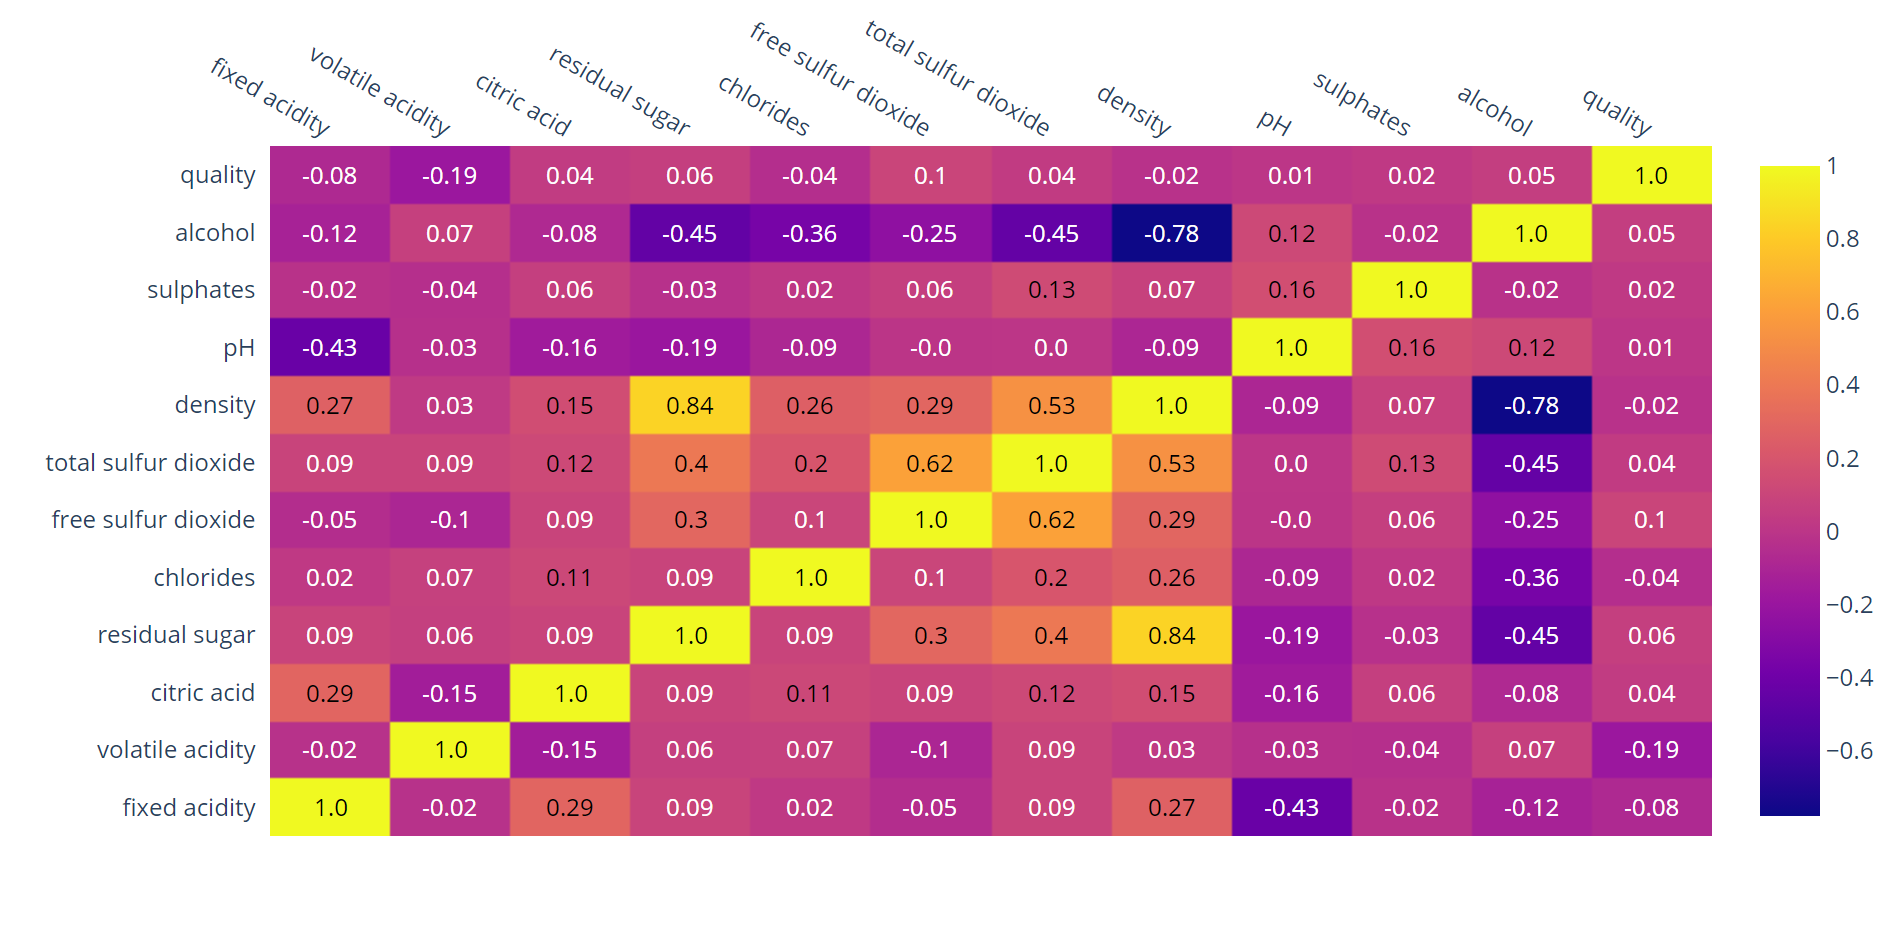

In [4]:
# Dividing dataset into label and feature sets
X = dataset.drop(['quality', 'density'], axis = 1) # Droping unecessary column and highly corelated column.
Y = dataset['quality'] # Labels
print(type(X))
print(type(Y))
print(X.shape)
print(Y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(4898, 10)
(4898,)


Here we are split the data set into train and test to check the model performance. We are using "recall" parameter in grid-search to train the model to give lease false negative. As we do not want our model to predict bad products as good. It might result in bad reputation of the company

(3428, 10)
(1470, 10)
Number of observations in each class before oversampling (training data): 
 1    3297
0     131
Name: quality, dtype: int64
Number of observations in each class after oversampling (training data): 
 1    3297
0    3297
dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



{'n_estimators': 100}
0.9663305283487379
free sulfur dioxide     0.196320
volatile acidity        0.147076
alcohol                 0.100641
total sulfur dioxide    0.090601
fixed acidity           0.086640
chlorides               0.083131
residual sugar          0.079286
citric acid             0.079200
sulphates               0.070684
pH                      0.066421
dtype: float64


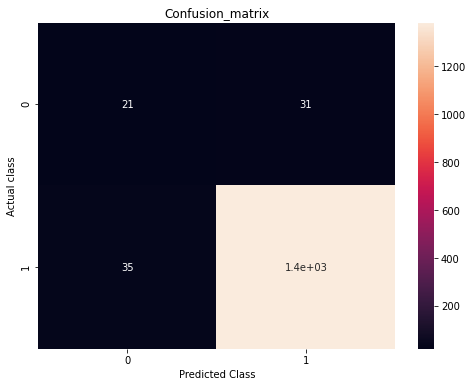

Confusion matrix: 
 [[  21   31]
 [  35 1383]]
TP:  1383
TN:  21
FP:  31
FN:  35


In [5]:
# Normalizing numerical features so that each feature has mean 0 and variance 1
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

# Dividing dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split( X_scaled, Y, test_size = 0.3, random_state = 100)

print(X_train.shape)
print(X_test.shape)

# Implementing Oversampling to balance the dataset; SMOTE stands for Synthetic Minority Oversampling TEchnique
print("Number of observations in each class before oversampling (training data): \n", pd.Series(Y_train).value_counts())

smote = SMOTE(random_state = 101)
X_train,Y_train = smote.fit_sample(X_train,Y_train)

print("Number of observations in each class after oversampling (training data): \n", pd.Series(Y_train).value_counts())

# Tuning the random forest parameter 'n_estimators' and implementing cross-validation using Grid Search
rfc = RandomForestClassifier(criterion='entropy', max_features='auto', random_state=1)
grid_param = {'n_estimators': [50, 100, 150, 200, 250, 300]}

gd_sr = GridSearchCV(estimator=rfc, param_grid=grid_param, scoring='recall', cv=5)

"""
In the above GridSearchCV(), scoring parameter should be set as follows:
scoring = 'accuracy' when you want to maximize prediction accuracy
scoring = 'recall' when you want to minimize false negatives
scoring = 'precision' when you want to minimize false positives
scoring = 'f1' when you want to balance false positives and false negatives (place equal emphasis on minimizing both)
"""

gd_sr.fit(X_train, Y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)

# Building random forest using the tuned parameter
rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_features='auto', random_state=1)
rfc.fit(X_train,Y_train)
featimp = pd.Series(rfc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Y_pred = rfc.predict(X_test)
conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

We go the significance of each feature on the final result. Using all the features might result in overfitting the model. Therefore we will train our final model just with the top 5/6 features.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



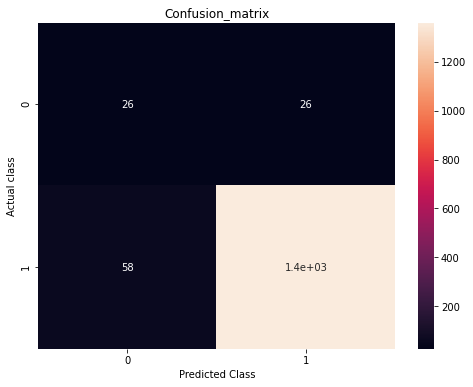

Confusion matrix: 
 [[  26   26]
 [  58 1360]]
TP:  1360
TN:  26
FP:  26
FN:  58


In [12]:
# Selecting features with higher sifnificance and redefining feature set
X = dataset[['free sulfur dioxide', 'volatile acidity', 'alcohol', 'total sulfur dioxide', 'fixed acidity']]

feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

# Dividing dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split( X_scaled, Y, test_size = 0.3, random_state = 100)

smote = SMOTE(random_state = 101)
X_train,Y_train = smote.fit_sample(X_train,Y_train)

rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_features='auto', random_state=1)
rfc.fit(X_train,Y_train)

Y_pred = rfc.predict(X_test)
conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

### **PCA** : Principal Component Analysis

Large datasets are increasingly widespread in many disciplines. In order to interpret such datasets, methods are required to drastically reduce their dimensionality in an interpretable way, such that most of the information in the data is preserved. Many techniques have been developed for this purpose, but principal component analysis (PCA) is one of the oldest and most widely used. Its idea is simple—reduce the dimensionality of a dataset, while preserving as much ‘variability’ (i.e. statistical information) as possible.


Variance explained by each of the n_components:  [0.38067246 0.20994741]
Total variance explained by the n_components:  0.5906198675490667


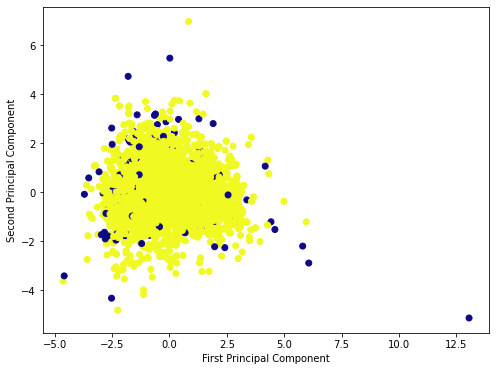

In [13]:
# Implementing PCA to visualize dataset
pca = PCA(n_components = 2)
pca.fit(X_scaled)
x_pca = pca.transform(X_scaled)
print("Variance explained by each of the n_components: ",pca.explained_variance_ratio_)
print("Total variance explained by the n_components: ",sum(pca.explained_variance_ratio_))

plt.figure(figsize = (8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=Y, cmap='plasma')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()


From the above visualisation, we observe that it is not an excellent representation of data. Therefore we need to use elbow plot to Clusters are natural groupings of data. K refers to the number of clusters. It is to find out how many good clusters can happen in the dataset.

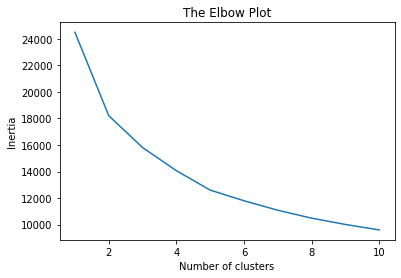

In [15]:
# Finding the number of clusters (K) - Elbow Plot Method
inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, random_state = 100)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('The Elbow Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()



Note that inertial drops as we increase the 
number of clusters.
The idea behind good clustering is having a small 
value of inertia, and small number of clusters.
The elbow point in the inertia graph is a good 
choice because after that the change in the 
value of inertia isn’t significant.
In the given plot, **K=2** is the optimal choice

Cluster Centers: 
 [[-0.55060484  0.02373913  0.53114877 -0.64395235 -0.07177173]
 [ 0.70258405 -0.03029165 -0.67775768  0.82169757  0.09158233]]


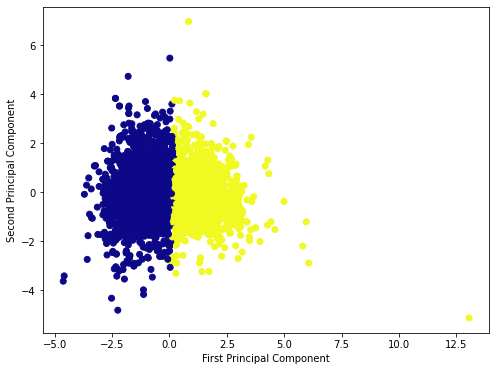

In [16]:
# If K=2
kmeans = KMeans(n_clusters = 2)
kmeans.fit(X_scaled)
print("Cluster Centers: \n",kmeans.cluster_centers_)
plt.figure(figsize = (8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=kmeans.labels_, cmap='plasma')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

We can observe that the visualisation is good and gives good information about data when we use KMeans.